## Assignment 2

By Lucas Kristiansson, Rikard Radovac and Carolina Rönnewall

**Task 1**

In [1]:
import pandas as pd

data_train = pd.read_csv('adult_train.csv')

Xtrain, Ytrain = data_train.iloc[:, :-1], data_train.iloc[:, -1]

data_test = pd.read_csv('adult_test.csv')

Xtest, Ytest = data_test.iloc[:, :-1], data_test.iloc[:, -1]


In [2]:
from sklearn.feature_extraction import DictVectorizer


train_dicts = Xtrain.to_dict('records')
test_dicts = Xtest.to_dict('records')
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(train_dicts)
X_test_encoded = dv.transform(test_dicts)




/Users/rikard/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = DecisionTreeClassifier(max_depth=3)
scores = cross_val_score(clf, X_train_encoded, Ytrain)
scores.mean()

0.8437702604618773

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
  
pipeline = make_pipeline(
  DictVectorizer(),
  DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(train_dicts, Ytrain)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [5]:
scores = cross_val_score(pipeline, train_dicts, Ytrain)
scores.mean()

0.8437702604618773

**Task 2**


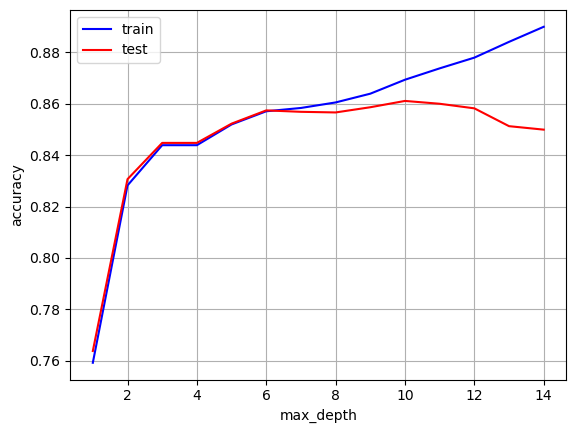

In [16]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

pred_test_values = []
pred_train_values = []
x = range(1, 15)
for max_depth in range(1, 15):
    pipeline = make_pipeline(
        DictVectorizer(),
        DecisionTreeClassifier(max_depth=max_depth)
        )

    pipeline.fit(train_dicts, Ytrain)

    pred_train_values.append(accuracy_score(Ytrain, pipeline.predict(train_dicts)))
    pred_test_values.append(accuracy_score(Ytest, pipeline.predict(test_dicts)))


plt.plot(x, pred_train_values, 'b', label='train')
plt.plot(x, pred_test_values, 'r', label='test')
plt.grid('True')
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.legend()

**Underfitting and overfitting in decision tree classifiers.**

We see that the test and train accuracy diverge when the max depth gets large, which is similar to what we got in the previous assignment (task 4 step 4).

**Underfitting and overfitting in random forest classifiers.**

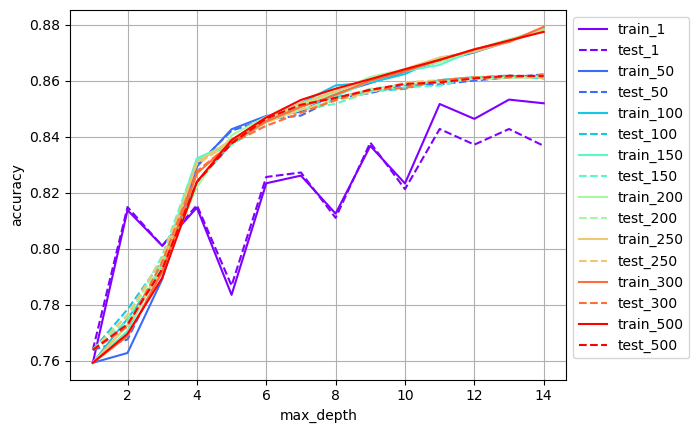

In [15]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cm as cm

num_estimators = [1, 50, 100, 150, 200, 250, 300, 500]

x = range(1, 15)
# give me list of 12 different colors to use for my plots:

colors = cm.rainbow(np.linspace(0, 1, len(num_estimators)))


for n_estimators, color in zip(num_estimators, colors):
    pred_test_values = []
    pred_train_values = []
    for max_depth in x:
        pipeline = make_pipeline(
            DictVectorizer(),
            RandomForestClassifier(
                max_depth=max_depth, n_estimators=n_estimators, n_jobs=-1
            ),
        )
        pipeline.fit(train_dicts, Ytrain)

        pred_train_values.append(accuracy_score(Ytrain, pipeline.predict(train_dicts)))
        pred_test_values.append(accuracy_score(Ytest, pipeline.predict(test_dicts)))
    plt.plot(x, pred_train_values, label=f"train_{n_estimators}", color=color)
    plt.plot(
        x, pred_test_values, label=f"test_{n_estimators}", color=color, linestyle="--"
    )
    plt.grid("True")
    plt.ylabel("accuracy")
    plt.xlabel("max_depth")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?

**Answer**

The difference is that a random forest with an ensemble size of 1 shows more fluctuation in the accuracy plot. This is caused by several factors:

- Bagging: The single decision tree in the random forest is trained on a subset of the whole training set.

- Bootstrapping: (is true by default in sklearn), the training dataset for the single decision tree is randomly sampled from the original training dataset

- randomness: Throughout the training when the tree is about to split a node, only a random subset of all inputs are used.

All of these factors cause the single decision tree in the random forest to act differently from training a single decision tree by its own.


What happens with the curve for random forests as the ensemble size grows?

**Answer**

As the ensamble size grows, the above factors cause the different ensamble members to be less correlated and thus resulting in a lower variance. This causes the average prediction accuracy to also have a lower variance and thus perform better, which we can see in the plot above.

What happens with the best observed test set accuracy as the ensemble size grows?

**Answer**

As can be seen in the plot above, when the ensemble size grows, the best accuracy seems to stagnate. This is probably caused by the way that random forest cannot overfit as the ensemble size grows and in our case there is no real difference between 50 and 300 estimators.

What happens with the training time as the ensemble size grows?

**Answer**

As the ensemble size grows, the computational cost also increases and the training time will be increasing linearly as a function of number of ensembles.

**Task 3**

In [17]:
pipeline = make_pipeline(
            DictVectorizer(),
            RandomForestClassifier(
                max_depth=8, n_estimators=50, n_jobs=-1
            ),
        )

pipeline.fit(train_dicts, Ytrain)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, n_estimators=50,
                                        n_jobs=-1))])

In [40]:

feature_names = pipeline.steps[0][1].feature_names_
feature_importances = pipeline.steps[1][1].feature_importances_

features = [(feature, importance) for feature, importance in zip(feature_names, feature_importances)]
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)
sorted_features[:5]

[('marital-status=Married-civ-spouse', 0.15123184487686384),
 ('relationship=Husband', 0.13927386269754202),
 ('capital-gain', 0.13855157268377857),
 ('education-num', 0.1185414130613544),
 ('age', 0.05311359822493974)]

Text(0.5, 0, 'feature')

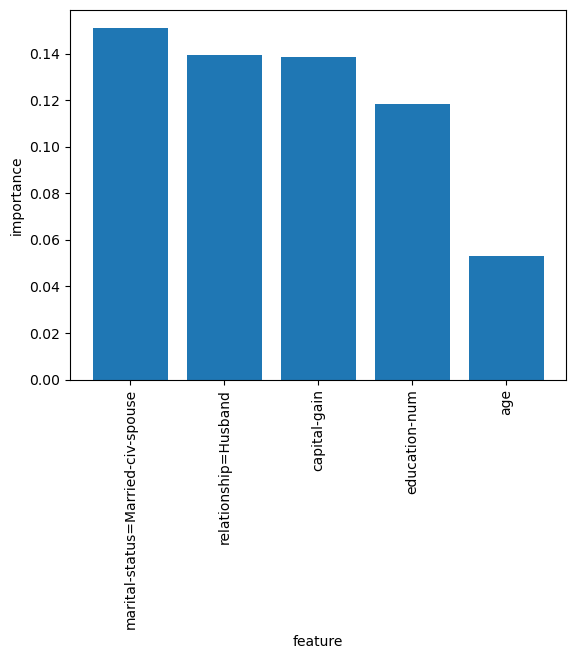

In [44]:

plt.bar([x[0] for x in sorted_features[:5]], [x[1] for x in sorted_features[:5]])
plt.xticks(rotation=90)
plt.ylabel("importance")
plt.xlabel("feature")


For your report, please also mention an alternative way to compute some sort of importance score of individual features

**Answer**

One alternative way to compute feature importance scores, aside from the default decision tree-based method, is to use permutation importance. This approach involves measuring the decrease in model performance after randomly permuting the values of a single feature while keeping all others fixed. By comparing the decrease in performance across multiple iterations, one can estimate the relative importance of each feature. This method has the advantage of being generally applicable to various types of models, unlike decision tree-based methods which may be biased towards specific types of interactions or correlations.